In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
import lightgbm as lgb
import gensim.downloader
from gensim.models import KeyedVectors

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submit.csv')

In [6]:
train.head()

,id,goal,country,duration,category1,category2,html_content,state
0,0,4001-5000,CH,29,publishing,young adult,"<div class=""contents""><div><span class=""bold"">...",0
1,1,3001-4000,NL,34,fashion,ready-to-wear,"<div class=""contents""><div><h1 class=""page-anc...",0
2,2,19001-20000,US,30,food,spaces,"<div class=""contents""><div><p> As our society ...",0
3,3,2001-3000,US,41,technology,3d printing,"<div class=""contents""><div><p>My name is Donal...",0
4,4,2001-3000,GB,29,technology,diy electronics,"<div class=""contents""><div><div class=""templat...",1


In [287]:
train.country.unique()

array(['CH', 'NL', 'US', 'GB', 'CA', 'ES', 'FR', 'DE', 'AU', 'IT', 'MX',
       'NZ', 'NO', 'DK', 'HK', 'SG', 'BE', 'SE', 'IE', 'JP', 'AT', 'LU'],
      dtype=object)

In [288]:
country_dict = {
    "CH": "EU",#スイス
    "NL": "EU",#オランダ
    "US": "AM",#アメリカ
    "GB": "EU",#イギリス
    "CA": "AM",#カナダ
    "ES": "EU",#スペイン
    "FR": "EU",#フランス
    "DE": "EU",#ドイツ
    "AU": "OS",#オーストラリア
    "IT": "EU",#イタリア
    "MX": "AM",#メキシコ
    "NZ": "OS",#ニュージーランド
    "NO": "EU",#ノルウェー
    "DK": "EU",#デンマーク
    "HK": "AS",#香港
    "SG": "AS",#シンガポール
    "BE": "EU",#ベルギー
    "SE": "EU",#スウェーデン
    "IE": "EU",#アイルランド
    "JP": "AS",#日本
    "AT": "EU",#オーストリア
    "LU": "EU",#ルクセンブルク
}

In [289]:
def add_region_column(df):
    df["region"] = ""
    for country in country_dict.keys():
        df["region"][df["country"]== country] = country_dict[country]
    return df

In [290]:
train_region = add_region_column(train)
train_region.head()

<ipython-input-289-94b1c3933de4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["region"][df["country"]== country] = country_dict[country]


,id,goal,country,duration,category1,category2,html_content,state,region
0,0,4001-5000,CH,29,publishing,young adult,"<div class=""contents""><div><span class=""bold"">...",0,EU
1,1,3001-4000,NL,34,fashion,ready-to-wear,"<div class=""contents""><div><h1 class=""page-anc...",0,EU
2,2,19001-20000,US,30,food,spaces,"<div class=""contents""><div><p> As our society ...",0,AM
3,3,2001-3000,US,41,technology,3d printing,"<div class=""contents""><div><p>My name is Donal...",0,AM
4,4,2001-3000,GB,29,technology,diy electronics,"<div class=""contents""><div><div class=""templat...",1,EU


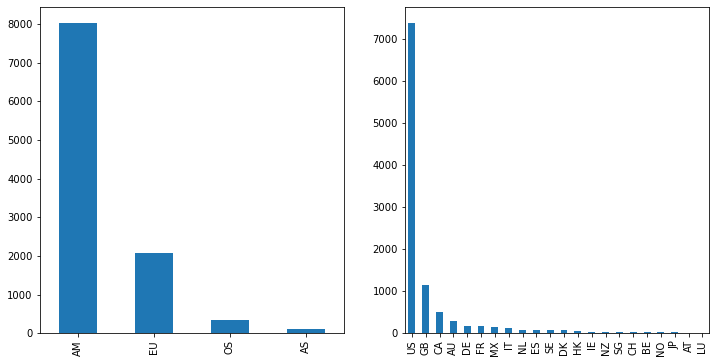

In [221]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
train_region.region.value_counts().plot(kind="bar")

plt.subplot(1,2,2)
train_region.country.value_counts().plot(kind="bar")

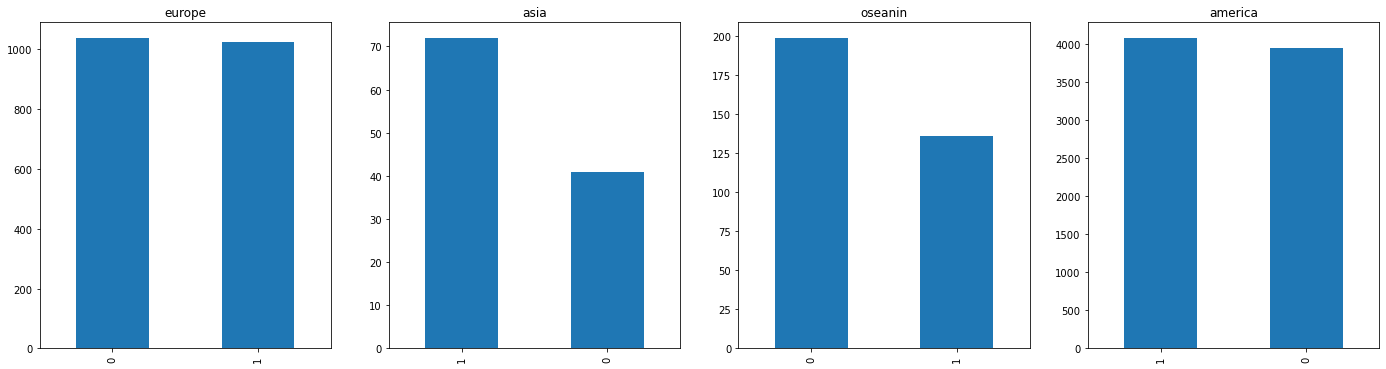

In [222]:
plt.figure(figsize=(24,6))

plt.subplot(1,4,1)
plt.title("europe")
train_region[train_region["region"] == "EU"]["state"].value_counts().plot(kind="bar")

plt.subplot(1,4,2)
plt.title("asia")
train_region[train_region["region"] == "AS"]["state"].value_counts().plot(kind="bar")

plt.subplot(1,4,3)
plt.title("oseanin")
train_region[train_region["region"] == "OS"]["state"].value_counts().plot(kind="bar")

plt.subplot(1,4,4)
plt.title("america")
train_region[train_region["region"] == "AM"]["state"].value_counts().plot(kind="bar")

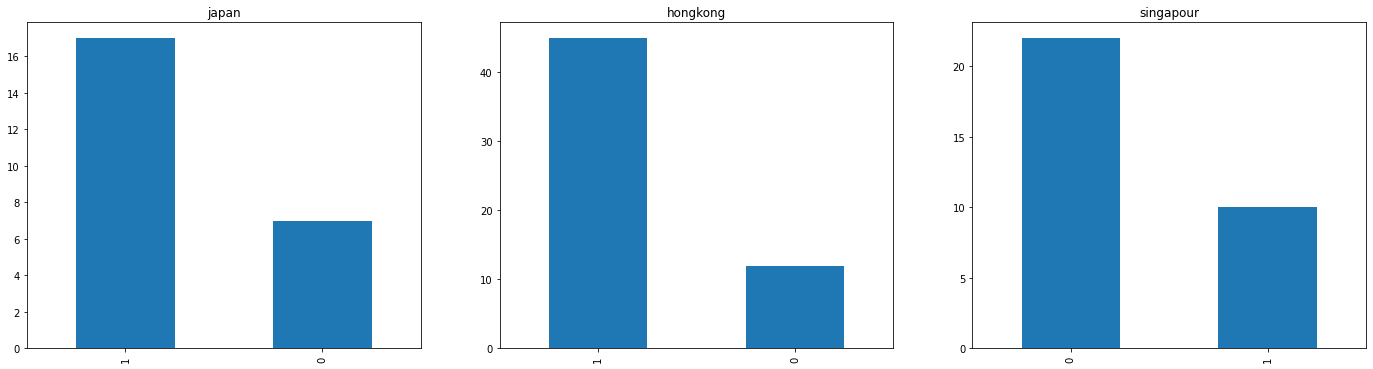

In [223]:
plt.figure(figsize=(24,6))

plt.subplot(1,3,1)
plt.title("japan")
train_region[train_region["country"] == "JP"]["state"].value_counts().plot(kind="bar")

plt.subplot(1,3,2)
plt.title("hongkong")
train_region[train_region["country"] == "HK"]["state"].value_counts().plot(kind="bar")

plt.subplot(1,3,3)
plt.title("singapour")
train_region[train_region["country"] == "SG"]["state"].value_counts().plot(kind="bar")

In [268]:
eu_countrys = train_region[train_region["region"] == "EU"].country.unique().tolist()
n_country = len(eu_countrys)
n_country//2

7

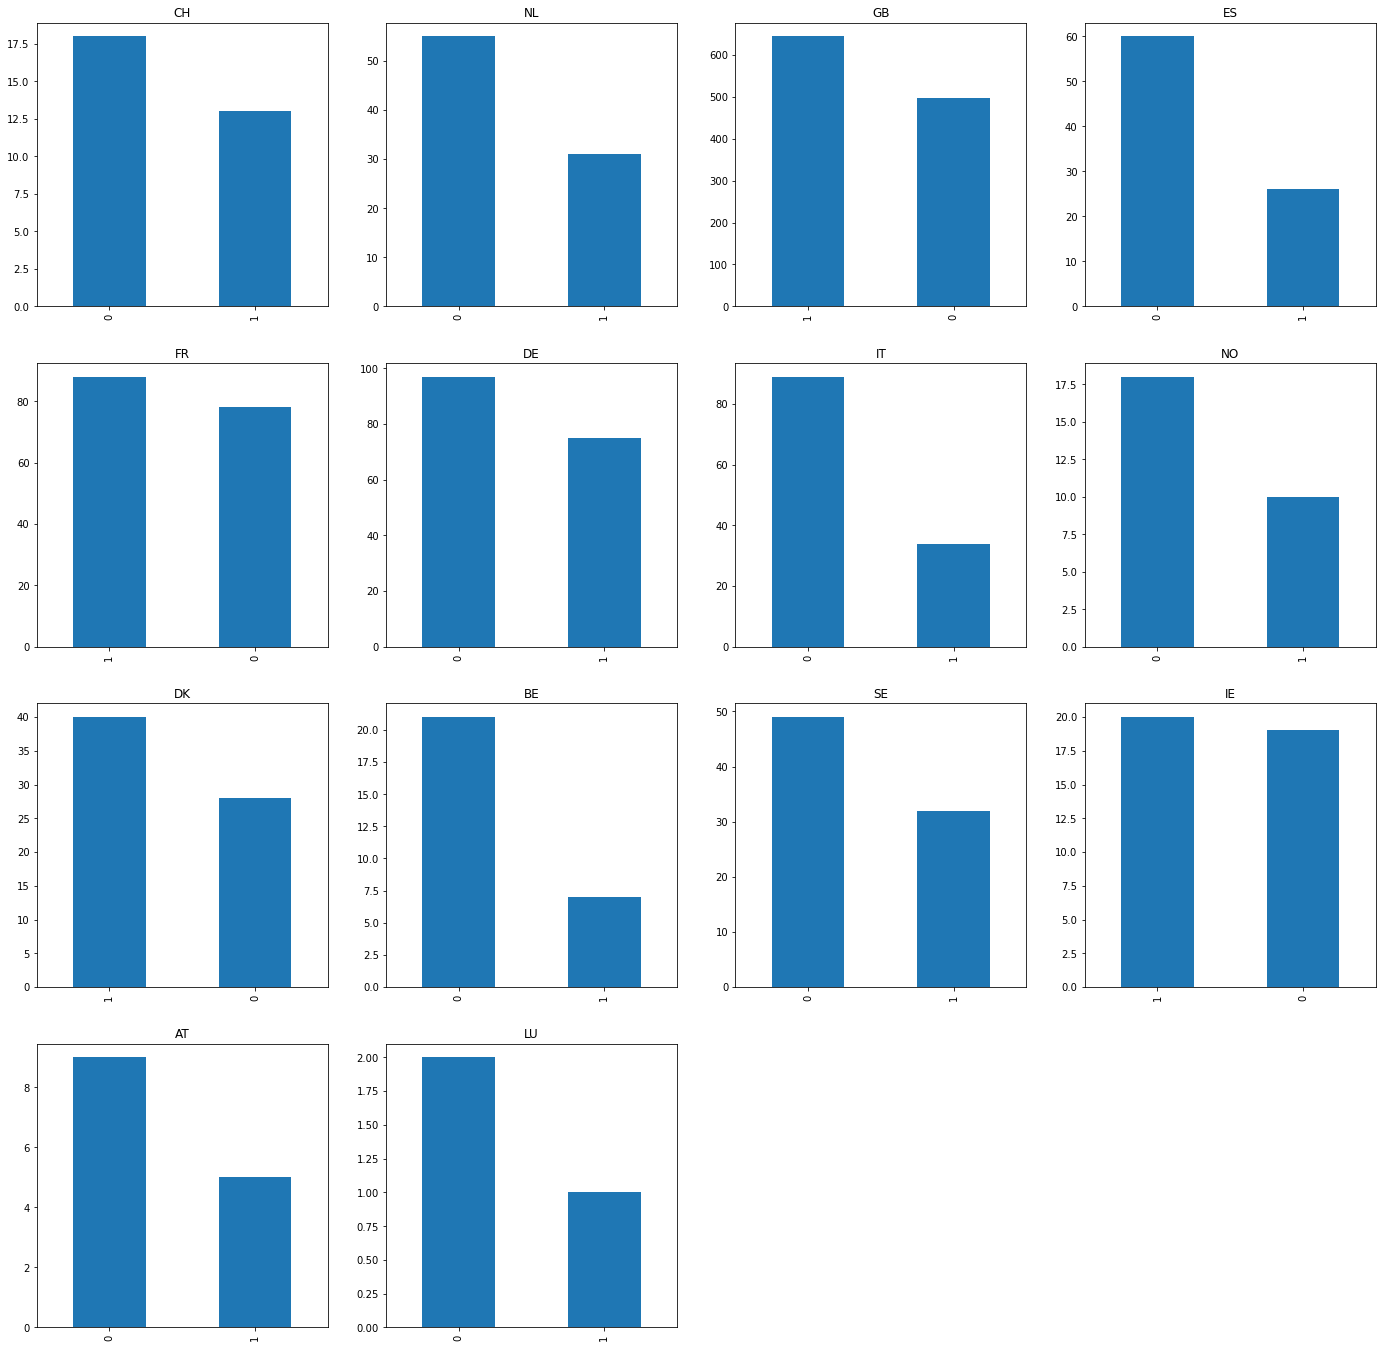

In [276]:
eu_countrys = train_region[train_region["region"] == "EU"].country.unique().tolist()
n_country = len(eu_countrys)
plt.figure(figsize=(24, 24))
for n, country in enumerate(eu_countrys):
    plt.subplot(4, 4, n+1)
    plt.title(country)
    train_region[train_region["country"] == country]["state"].value_counts().plot(kind="bar")

In [145]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [313]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')
glove_short_vectors = gensim.downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [325]:
def get_wordvec_dict(df, glove_vectors, vec_size):
    wordvec_dict = {}
    for word in df["category1"].unique().tolist():
        try:
            wordvec = glove_vectors[word]
        except:
            try:
                words = list(word.split())
                wordvec = np.zeros(vec_size)
                for _word in words:
                    wordvec += glove_vectors[_word]
            except:
                print(word)
        wordvec_dict[word] = wordvec
    for word in df["category2"].unique().tolist():
        try:
            wordvec = glove_vectors[word]
        except:
            try:
                words = list(word.split())
                wordvec = np.zeros(vec_size)
                for _word in words:
                    wordvec += glove_vectors[_word]
            except:
                print(word)
        wordvec_dict[word] = wordvec
    return wordvec_dict

In [326]:
wordvec_dict = get_wordvec_dict(test, glove_vectors, 50)
wordvec_df = pd.DataFrame(wordvec_dict.values(), wordvec_dict.keys(), )
wordvec_df

makerspaces
children's books
farmer's markets


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
dance,-0.997160,0.613480,-1.76860,0.087052,-0.246440,0.199840,-0.258920,-0.031309,-0.431170,1.084400,...,-0.27224,-0.21765,-0.559310,-0.401490,0.563950,-0.199150,0.726450,-1.518400,-0.878630,0.21860
crafts,-0.659740,-0.057610,-1.53320,0.024523,0.199050,-0.533150,-1.077600,-1.223600,-0.060343,0.138960,...,0.18316,-0.24894,0.422590,-0.037094,0.986900,0.320100,-0.016904,-0.522740,-0.033062,-0.15011
design,0.259700,0.520620,-0.26789,-0.059460,-0.131210,0.628620,-0.535530,-1.750500,-0.130900,-0.106760,...,0.71661,-0.64940,0.238370,-0.065145,-0.066195,0.282500,0.510720,-0.045163,0.121070,0.57358
technology,-0.257220,-0.093385,1.13710,0.951470,-0.451560,-0.553020,-0.486370,-1.647600,0.594220,0.752110,...,0.34616,-0.32074,0.265520,0.488980,0.656380,0.504320,0.801570,0.581820,-0.068956,0.39337
food,0.472220,-0.445450,-0.51833,-0.268180,0.444270,-0.251080,-0.992820,-0.901980,1.872900,0.039081,...,0.06884,0.59978,0.539670,-0.061752,1.297500,0.923230,-0.809450,0.349320,0.339340,0.25499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
workshops,0.358940,0.482420,-0.89024,-0.370560,-0.721480,-0.245330,-0.626310,-0.586180,0.295880,0.028771,...,0.23806,-0.88374,-0.156120,0.277400,1.009400,-0.028763,0.319680,0.162600,-0.924950,-0.21756
letterpress,-0.772910,-0.916940,-0.26947,-0.382750,-0.408200,0.087058,0.113490,-0.468650,-0.342490,-0.025310,...,1.70560,-0.33245,-0.641270,0.741270,0.243930,-0.166830,0.659630,1.050200,-0.795050,-0.45721
fabrication tools,0.183585,-1.122790,0.85767,1.478520,-0.521811,0.442580,0.790560,-1.767950,0.539030,0.998972,...,1.44320,-1.68663,0.186973,1.677020,2.269300,-0.302337,0.969997,1.373900,0.131589,-0.37817
toys,0.117380,-0.788640,0.20307,0.406090,0.535720,0.668530,-1.030300,-2.066600,0.677460,0.413010,...,-0.36473,0.21090,0.167090,0.186730,1.364100,1.111100,-0.178350,-0.314370,0.124970,-0.14976


In [327]:
wordvec_short_dict = get_wordvec_dict(test, glove_short_vectors, 25)
wordvec_short_df = pd.DataFrame(wordvec_short_dict.values(), wordvec_short_dict.keys(), )
wordvec_schort_df

periodicals
makerspaces
children's books
farmer's markets
3d printing


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
dance,-0.443130,0.158310,0.748980,-0.00311,0.28313,0.055192,1.81980,0.62841,0.736930,-0.67881,...,0.79015,-0.278510,-0.781140,-0.599550,0.515400,-0.93138,0.48888,-0.004216,-0.18930,0.94461
crafts,-1.552600,-0.071903,0.363050,-0.35570,1.48940,-0.379400,0.52030,-2.29990,0.628220,-1.01460,...,-0.92179,0.322860,-0.454300,0.600560,0.600930,-0.88226,-1.04760,-1.196900,0.28616,0.30466
design,-0.314810,-0.884250,-0.397480,-0.86489,1.58820,-0.054011,0.26496,-0.47508,1.858600,-0.66278,...,0.12651,0.456670,0.050883,-0.089500,0.388220,-1.35610,-1.22410,-1.338800,0.10004,-0.61863
technology,0.497900,0.071279,-0.918320,-0.96680,0.92633,-0.270020,0.64588,-1.10560,1.831900,-0.12372,...,-0.30791,-0.008201,0.770160,1.286500,0.090809,-0.30148,-1.46490,-0.868590,-0.32630,-0.71399
food,-0.578890,0.521370,-0.178920,0.22320,0.61681,0.176160,1.68290,-1.35000,0.027486,0.95868,...,-0.44304,1.350800,-1.017600,0.069551,0.023407,-0.21827,-0.57156,-0.745940,0.26706,0.96434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
workshops,0.048832,1.047300,-0.004906,-0.99757,0.83575,-0.162770,-0.29680,-1.84880,0.300190,-1.18230,...,0.42987,0.152330,-0.016965,-0.153370,0.227580,-1.37620,-1.34890,-1.722100,-0.00311,0.77235
letterpress,-0.239870,-0.342700,0.192490,-0.59742,0.33070,-0.579000,0.12782,-1.69330,0.503870,-1.14660,...,0.43200,0.954770,-0.007742,0.646460,0.912840,-1.33250,-0.65417,-0.564500,-0.59070,-0.77793
fabrication tools,0.019140,0.181670,-1.611760,-0.27098,2.62389,0.163999,-0.97788,-2.79860,2.818600,-1.32001,...,0.43830,0.917390,1.093700,1.773020,1.092340,-0.99257,-1.46626,-1.509240,-0.26695,-0.27954
toys,-0.590960,-0.052383,0.547250,-0.16981,0.85959,-0.348170,0.63049,-1.03910,-0.134350,-0.22134,...,0.26307,1.023500,-0.821250,1.055000,0.430870,-0.80351,-0.50943,-0.318330,-0.65518,0.35314


In [331]:
def word2vec_for_df(df, wordvec_df, vec_size):
    for n in range(vec_size*2):
        df[n] = 0.
    for i in range(vec_size):
        category2s = df["category2"].unique()
        category1s = df["category1"].unique()
        for category2 in category2s:
            df[i][df["category2"] == category2] = wordvec_df.loc[category2,i]
        for category1 in category1s:
            df[i+vec_size][df["category1"] == category1] = wordvec_df.loc[category1,i]
            
    return df

In [292]:
def add_column_about_goalrange(df_origin):
    df = df_origin.copy()
    df["goal_min"] = df["goal_max"] = df["range/min"] = df["max/min"] = 0.0
    for n in tqdm(range(len(df))):
        try:
            min_, max_ = map(float, df["goal"][n].split('-'))
        except:
            min_ = float(df["goal"][n].rstrip('+'))
            max_ = float(100999)#　上限無しは100999で置き換える
            
        df["goal_min"][n], df["goal_max"][n] = min_, max_
        df["range/min"][n] = (max_ - min_) / min_
        df["max/min"][n] = max_ / min_
        
    return df

train_added = add_column_about_goalrange(train)
train_added.head(13)

  0%|          | 0/10545 [00:00<?, ?it/s]<ipython-input-292-1fa39faaecd4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["goal_min"][n], df["goal_max"][n] = min_, max_
<ipython-input-292-1fa39faaecd4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["range/min"][n] = (max_ - min_) / min_
<ipython-input-292-1fa39faaecd4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["max/min"][n] = max_ / min_
100%|██████████| 10545/105

,id,goal,country,duration,category1,category2,html_content,state,region,goal_min,goal_max,range/min,max/min
0,0,4001-5000,CH,29,publishing,young adult,"<div class=""contents""><div><span class=""bold"">...",0,EU,4001.0,5000.0,0.249688,1.249688
1,1,3001-4000,NL,34,fashion,ready-to-wear,"<div class=""contents""><div><h1 class=""page-anc...",0,EU,3001.0,4000.0,0.332889,1.332889
2,2,19001-20000,US,30,food,spaces,"<div class=""contents""><div><p> As our society ...",0,AM,19001.0,20000.0,0.052576,1.052576
3,3,2001-3000,US,41,technology,3d printing,"<div class=""contents""><div><p>My name is Donal...",0,AM,2001.0,3000.0,0.499250,1.499250
4,4,2001-3000,GB,29,technology,diy electronics,"<div class=""contents""><div><div class=""templat...",1,EU,2001.0,3000.0,0.499250,1.499250
5,5,1-1000,US,19,photography,fine art,"<div class=""contents""><div><h1 class=""page-anc...",1,AM,1.0,1000.0,999.000000,1000.000000
6,6,3001-4000,GB,59,fashion,apparel,"<div class=""contents""><div><p>We are raising f...",0,EU,3001.0,4000.0,0.332889,1.332889
7,7,1-1000,US,20,art,mixed media,"<div class=""contents""><div><p>Hello world,</p>...",1,AM,1.0,1000.0,999.000000,1000.000000
8,8,2001-3000,US,28,publishing,periodicals,"<div class=""contents""><div><p>You are cool wit...",1,AM,2001.0,3000.0,0.499250,1.499250
9,9,1001-2000,GB,21,film & video,documentary,"<div class=""contents""><div><h1 class=""page-anc...",1,EU,1001.0,2000.0,0.998002,1.998002


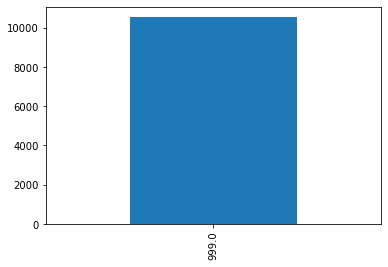

In [260]:
plt.figure()
train_added.goal_range.value_counts().plot(kind="bar")

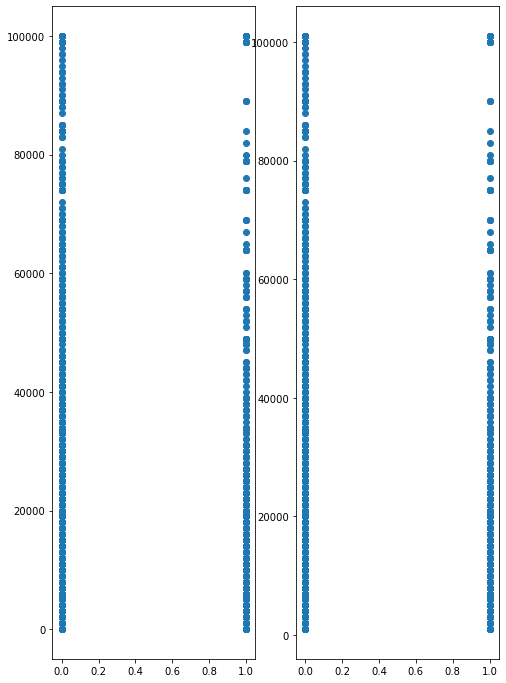

In [283]:
plt.figure(figsize=(8,12))

plt.subplot(1,2,1)
plt.scatter(train_added.state, train_added.goal_min)

plt.subplot(1,2,2)
plt.scatter(train_added.state, train_added.goal_max)

In [235]:
def preprocess(df, encode_cols):
    le = LabelEncoder()
    for f in encode_cols:
        try:encode_cols = ["country", "category1", "category2", "region"]
train_encoded = preprocess(train, encode_cols)
train_encoded.head()
            df[f] = le.fit_transform(list(df[f].values))
        except:
            print(f)
    return df

In [308]:
encode_cols = ["country", "category1", "category2", "region"]
train_encoded = preprocess(train, encode_cols)
train_encoded.head()

region


,id,goal,country,duration,category1,category2,html_content,state
0,0,4001-5000,4,28,12,142,"<div class=""contents""><div><span class=""bold"">...",0
1,1,3001-4000,16,33,5,108,"<div class=""contents""><div><h1 class=""page-anc...",0
2,2,19001-20000,21,29,7,122,"<div class=""contents""><div><p> As our society ...",0
3,3,2001-3000,21,40,13,0,"<div class=""contents""><div><p>My name is Donal...",0
4,4,2001-3000,9,28,13,33,"<div class=""contents""><div><div class=""templat...",1


In [168]:
train_added_encoded = preprocess(train_added, encode_cols)
train_added_encoded.head()

,id,goal,country,duration,category1,category2,html_content,state,goal_min,goal_max
0,0,4001-5000,4,28,12,142,"<div class=""contents""><div><span class=""bold"">...",0,4001.0,5000.0
1,1,3001-4000,16,33,5,108,"<div class=""contents""><div><h1 class=""page-anc...",0,3001.0,4000.0
2,2,19001-20000,21,29,7,122,"<div class=""contents""><div><p> As our society ...",0,19001.0,20000.0
3,3,2001-3000,21,40,13,0,"<div class=""contents""><div><p>My name is Donal...",0,2001.0,3000.0
4,4,2001-3000,9,28,13,33,"<div class=""contents""><div><div class=""templat...",1,2001.0,3000.0


In [169]:
print(min(train.goal_min), min(train.goal_max), max(train.goal_min), max(train.goal_max))

1.0 1000.0 100000.0 inf


In [170]:
train_added_encoded.to_csv('data/train_added_encoded.csv', index=False)
train_saved = pd.read_csv('data/train_added_encoded.csv')
train_saved.head(13)

,id,goal,country,duration,category1,category2,html_content,state,goal_min,goal_max
0,0,4001-5000,4,28,12,142,"<div class=""contents""><div><span class=""bold"">...",0,4001.0,5000.0
1,1,3001-4000,16,33,5,108,"<div class=""contents""><div><h1 class=""page-anc...",0,3001.0,4000.0
2,2,19001-20000,21,29,7,122,"<div class=""contents""><div><p> As our society ...",0,19001.0,20000.0
3,3,2001-3000,21,40,13,0,"<div class=""contents""><div><p>My name is Donal...",0,2001.0,3000.0
4,4,2001-3000,9,28,13,33,"<div class=""contents""><div><div class=""templat...",1,2001.0,3000.0
5,5,1-1000,21,18,11,49,"<div class=""contents""><div><h1 class=""page-anc...",1,1.0,1000.0
6,6,3001-4000,9,58,5,7,"<div class=""contents""><div><p>We are raising f...",0,3001.0,4000.0
7,7,1-1000,21,19,0,77,"<div class=""contents""><div><p>Hello world,</p>...",1,1.0,1000.0
8,8,2001-3000,21,27,12,89,"<div class=""contents""><div><p>You are cool wit...",1,2001.0,3000.0
9,9,1001-2000,9,20,6,34,"<div class=""contents""><div><h1 class=""page-anc...",1,1001.0,2000.0


In [171]:
test_added = add_column_about_goalrange(test)
test_added_encoded = preprocess(test_added, encode_cols)
test_added_encoded.to_csv('data/test_added_encoded.csv', index=False)
test_saved = pd.read_csv('data/test_added_encoded.csv')
test_saved.head()

  0%|          | 0/10544 [00:00<?, ?it/s]<ipython-input-165-fc74bba212a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["goal_min"][n], df["goal_max"][n] = map(float, df["goal"][n].split('-'))
<ipython-input-165-fc74bba212a8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["goal_min"][n] = float(df["goal"][n].rstrip('+'))
<ipython-input-165-fc74bba212a8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["goal_max"][n] = flo

,id,goal,country,duration,category1,category2,html_content,goal_min,goal_max
0,10545,1-1000,21,59,3,88,"<div class=""contents""><div><p>We are presentin...",1.0,1000.0
1,10546,8001-9000,21,29,2,100,"<div class=""contents""><div><a href=""http://dum...",8001.0,9000.0
2,10547,9001-10000,21,59,4,101,"<div class=""contents""><div><div class=""templat...",9001.0,10000.0
3,10548,1001-2000,21,29,13,119,"<div class=""contents""><div><p>This is my video...",1001.0,2000.0
4,10549,4001-5000,21,58,13,119,"<div class=""contents""><div><h1 class=""page-anc...",4001.0,5000.0


In [293]:
def concat_train_test(train, test):
    all_df = pd.merge(train, test, how="outer")
    all_df["data_type"] = ""
    for n in range(len(all_df)):
        all_df["data_type"][n] = "test" if np.isnan(all_df["state"][n]) else "train"
    return all_df

In [ ]:
all_df_added = concat_train_test(train_added, test_added)
all_df_added_encoded = preprocess(all_df_added, encode_cols)
all_df_added_encoded.to_csv('data/all_added_encoded.csv', index=False)
all_saved = pd.read_csv('data/all_added_encoded.csv')
all_saved.head()

In [296]:
all_df = concat_train_test(train, test)
all_df

<ipython-input-293-685f4a3720c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df["data_type"][n] = "test" if np.isnan(all_df["state"][n]) else "train"


,id,goal,country,duration,category1,category2,html_content,state,data_type
0,0,4001-5000,CH,29,publishing,young adult,"<div class=""contents""><div><span class=""bold"">...",0.0,train
1,1,3001-4000,NL,34,fashion,ready-to-wear,"<div class=""contents""><div><h1 class=""page-anc...",0.0,train
2,2,19001-20000,US,30,food,spaces,"<div class=""contents""><div><p> As our society ...",0.0,train
3,3,2001-3000,US,41,technology,3d printing,"<div class=""contents""><div><p>My name is Donal...",0.0,train
4,4,2001-3000,GB,29,technology,diy electronics,"<div class=""contents""><div><div class=""templat...",1.0,train
...,...,...,...,...,...,...,...,...,...
21084,21084,9001-10000,US,30,food,drinks,"<div class=""contents""><div><p>Its time to get ...",NaN,test
21085,21085,1-1000,US,29,food,small batch,"<div class=""contents""><div><p>I have been roas...",NaN,test
21086,21086,1001-2000,US,27,crafts,pottery,"<div class=""contents""><div><p> I have ...",NaN,test
21087,21087,2001-3000,US,30,design,graphic design,"<div class=""contents""><div><h1 class=""page-anc...",NaN,test


In [178]:
all_df_vectorized = word2vec_for_df(all_df)
all_df_added_vectorized = add_column_about_goalrange(all_df_vectorized)
all_df_added_encoded_vectorized = preprocess(all_df_added_vectorized, encode_cols)
all_df_added_encoded_vectorized.to_csv("data/all_added_encoded_vectorized.csv", index=False)

<ipython-input-164-3ce94cd91ef9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df["category2"] == category2] = wordvec_df.loc[category2,i]
  0%|          | 0/21089 [00:00<?, ?it/s]<ipython-input-165-fc74bba212a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["goal_min"][n], df["goal_max"][n] = map(float, df["goal"][n].split('-'))
<ipython-input-165-fc74bba212a8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["goal_m

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('goal_min(top20)')
train_saved.goal_min.value_counts().plot(kind='bar')

plt.subplot(1,2,2)
plt.title('goal_max(top20)')
train_saved.goal_max.value_counts().plot(kind='bar')

In [310]:
all_df_region = add_region_column(all_df)
all_df_region_added = add_column_about_goalrange(all_df_region)
all_df_region_added_vectorized = word2vec_for_df(all_df_region_added)
all_df_region_added_encoded_vectorized = preprocess(all_df_region_added_vectorized, encode_cols)
all_df_region_added_encoded_vectorized

<ipython-input-289-94b1c3933de4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["region"][df["country"]== country] = country_dict[country]
  0%|          | 0/21089 [00:00<?, ?it/s]<ipython-input-292-1fa39faaecd4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["goal_min"][n], df["goal_max"][n] = min_, max_
<ipython-input-292-1fa39faaecd4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["range/min"][n] = (max_ - min_) / m

,id,goal,country,duration,category1,category2,html_content,state,data_type,region,...,90,91,92,93,94,95,96,97,98,99
0,0,4001-5000,4,28,12,143,"<div class=""contents""><div><span class=""bold"">...",0.0,train,2,...,1.42210,-0.69300,-0.31807,0.478270,-0.385140,0.10672,-0.458820,0.403570,-0.449540,-0.20497
1,1,3001-4000,16,33,5,108,"<div class=""contents""><div><h1 class=""page-anc...",0.0,train,2,...,0.43933,0.39159,0.15099,-0.202060,0.537840,-0.27545,0.313690,-0.564600,0.326540,0.80751
2,2,19001-20000,21,29,7,122,"<div class=""contents""><div><p> As our society ...",0.0,train,0,...,0.06884,0.59978,0.53967,-0.061752,1.297500,0.92323,-0.809450,0.349320,0.339340,0.25499
3,3,2001-3000,21,40,13,0,"<div class=""contents""><div><p>My name is Donal...",0.0,train,0,...,0.34616,-0.32074,0.26552,0.488980,0.656380,0.50432,0.801570,0.581820,-0.068956,0.39337
4,4,2001-3000,9,28,13,33,"<div class=""contents""><div><div class=""templat...",1.0,train,2,...,0.34616,-0.32074,0.26552,0.488980,0.656380,0.50432,0.801570,0.581820,-0.068956,0.39337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21084,21084,9001-10000,21,29,7,36,"<div class=""contents""><div><p>Its time to get ...",NaN,test,0,...,0.06884,0.59978,0.53967,-0.061752,1.297500,0.92323,-0.809450,0.349320,0.339340,0.25499
21085,21085,1-1000,21,28,7,117,"<div class=""contents""><div><p>I have been roas...",NaN,test,0,...,0.06884,0.59978,0.53967,-0.061752,1.297500,0.92323,-0.809450,0.349320,0.339340,0.25499
21086,21086,1001-2000,21,26,2,98,"<div class=""contents""><div><p> I have ...",NaN,test,0,...,0.18316,-0.24894,0.42259,-0.037094,0.986900,0.32010,-0.016904,-0.522740,-0.033062,-0.15011
21087,21087,2001-3000,21,29,4,56,"<div class=""contents""><div><h1 class=""page-anc...",NaN,test,0,...,0.71661,-0.64940,0.23837,-0.065145,-0.066195,0.28250,0.510720,-0.045163,0.121070,0.57358


In [312]:
all_df_region_added_encoded_vectorized.to_csv("data/all_region_added_encoded_vectorized.csv", index=False)

In [332]:
all_df_region = add_region_column(all_df)
all_df_region_added = add_column_about_goalrange(all_df_region)
all_df_region_added_vectorized = word2vec_for_df(all_df_region_added, wordvec_short_df, 25)
all_df_region_added_encoded_vectorized = preprocess(all_df_region_added_vectorized, encode_cols)
all_df_region_added_encoded_vectorized

<ipython-input-289-94b1c3933de4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["region"][df["country"]== country] = country_dict[country]
  0%|          | 0/21089 [00:00<?, ?it/s]<ipython-input-292-1fa39faaecd4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["goal_min"][n], df["goal_max"][n] = min_, max_
<ipython-input-292-1fa39faaecd4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["range/min"][n] = (max_ - min_) / m

,id,goal,country,duration,category1,category2,html_content,state,data_type,region,...,40,41,42,43,44,45,46,47,48,49
0,0,4001-5000,4,28,12,143,"<div class=""contents""><div><span class=""bold"">...",0.0,train,2,...,-0.094082,-0.116380,0.733980,0.159810,0.261700,-0.39400,-1.77100,-1.43360,-0.64829,-0.82776
1,1,3001-4000,16,33,5,108,"<div class=""contents""><div><h1 class=""page-anc...",0.0,train,2,...,0.168950,0.001122,-0.745100,-0.140370,1.125900,-1.11870,-0.78684,-1.28740,-0.84603,-0.25663
2,2,19001-20000,21,29,7,122,"<div class=""contents""><div><p> As our society ...",0.0,train,0,...,-0.443040,1.350800,-1.017600,0.069551,0.023407,-0.21827,-0.57156,-0.74594,0.26706,0.96434
3,3,2001-3000,21,40,13,0,"<div class=""contents""><div><p>My name is Donal...",0.0,train,0,...,-0.307910,-0.008201,0.770160,1.286500,0.090809,-0.30148,-1.46490,-0.86859,-0.32630,-0.71399
4,4,2001-3000,9,28,13,33,"<div class=""contents""><div><div class=""templat...",1.0,train,2,...,-0.307910,-0.008201,0.770160,1.286500,0.090809,-0.30148,-1.46490,-0.86859,-0.32630,-0.71399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21084,21084,9001-10000,21,29,7,36,"<div class=""contents""><div><p>Its time to get ...",NaN,test,0,...,-0.443040,1.350800,-1.017600,0.069551,0.023407,-0.21827,-0.57156,-0.74594,0.26706,0.96434
21085,21085,1-1000,21,28,7,117,"<div class=""contents""><div><p>I have been roas...",NaN,test,0,...,-0.443040,1.350800,-1.017600,0.069551,0.023407,-0.21827,-0.57156,-0.74594,0.26706,0.96434
21086,21086,1001-2000,21,26,2,98,"<div class=""contents""><div><p> I have ...",NaN,test,0,...,-0.921790,0.322860,-0.454300,0.600560,0.600930,-0.88226,-1.04760,-1.19690,0.28616,0.30466
21087,21087,2001-3000,21,29,4,56,"<div class=""contents""><div><h1 class=""page-anc...",NaN,test,0,...,0.126510,0.456670,0.050883,-0.089500,0.388220,-1.35610,-1.22410,-1.33880,0.10004,-0.61863


In [333]:
all_df_region_added_encoded_vectorized.to_csv("data/all_region_added_encoded_shortvectorized.csv", index=False)